In [18]:
import sys
import os
import datetime as dt
import pcse
from pcse.fileinput import YAMLCropDataProvider, CABOFileReader, YAMLAgroManagementReader
from pcse.exceptions import PCSEError, PartitioningError
from pcse.util import WOFOST80SiteDataProvider, WOFOST72SiteDataProvider
from pcse.base import ParameterProvider
from pcse.fileinput import YAMLAgroManagementReader
from pcse.fileinput import ExcelWeatherDataProvider
from pcse.models import Wofost80_NWLP_FD_beta as Wofost80_NWLP_FD
from pcse.models import Wofost72_WLP_FD
from tqdm import tqdm
import pandas as pd
import numpy as np
from wofostTool import overwrite_para, isdir_demo, my_crop_dict, my_agro
import datetime as dt

from pydream.core import run_dream
from pydream.parameters import SampledParam
from pydream.convergence import Gelman_Rubin
from scipy.stats import norm, uniform
import inspect
import os.path


In [19]:
pydream_path = os.path.dirname(inspect.getfile(run_dream))


## 验证数据集
doa_list = [74, 109]
dom_list = [70, 102]
doe_list = [9, 8]

## WOFOST模型初始化参数
data_dir = os.path.join("F://paper_code//wofost", "data")
cropfile = os.path.join(data_dir, 'npkfile', 'wofost_npk.crop')
cropd = CABOFileReader(cropfile)
soilfile = os.path.join(data_dir, 'soil', 'ec3_copy1.soil')
soild = CABOFileReader(soilfile)

sited = WOFOST72SiteDataProvider(WAV=18)
global parameters
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

with open("../data/npkfile/wofost_npk2022.agro", 'r') as f:
    yaml_agro_2022 = f.read()
with open("../data/npkfile/wofost_npk2021.agro", 'r') as f:
    yaml_agro_2021 = f.read()

weatherfile = os.path.join(data_dir, 'meteo', 'WOFOSTYL.xlsx')
wdp = ExcelWeatherDataProvider(weatherfile)

agro_list = [my_agro(yaml_agro_2021, 180), my_agro(yaml_agro_2021, 180)]


## 读取模型参数

In [112]:
import pickle
with open("./TSUM1/old_samples.pkl", "rb") as f:
    old_samples = pickle.load(f)

burnin = 90

In [113]:
samples = np.concatenate((old_samples[0][burnin:, :], old_samples[1][burnin:, :],
                          old_samples[2][burnin:, :], old_samples[3][burnin:, :], old_samples[4][burnin:, :]))


## 读取似然值

In [118]:
logps = np.load("./TSUM1/wofost_dreamzs_5chain_logps_chain_0_2000.npy")
parame = np.load("./TSUM1/wofost_dreamzs_5chain_sampled_params_chain_0_2000.npy")

In [125]:
df = pd.DataFrame(np.concatenate((logps, parame), axis=1), columns=['logps', 'TSUMEM', "TSUM1", 'TSUM2'])
df_max_logps = df[df['logps'] == df['logps'].max()]


In [127]:
df_max_logps.iloc[0, 1]

86.64871682677308

## 角点图

In [116]:
import corner

(9550, 3)

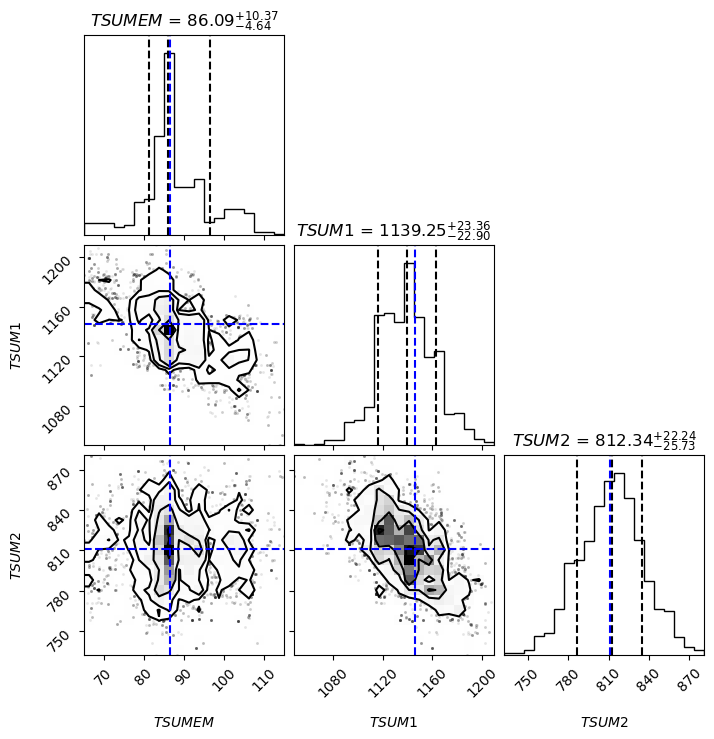

In [140]:
(_, ndim) = samples.shape

figure = corner.corner(
    samples,
    labels=[
        r"$TSUMEM$",
        r"$TSUM1$",
        r"$TSUM2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

axes = np.array(figure.axes).reshape((ndim, ndim))

for i in range(ndim):
    for j in range(ndim):
        ax = axes[i, j]
        if j <= i:
            ax.axvline(x=df_max_logps.iloc[0, j + 1], color="b", linestyle="--")
        if j < i:
            # print(df_max_logps.iloc[0, j + 1])
            ax.axhline(y=df_max_logps.iloc[0, i + 1], color="b", linestyle="--")
            


In [29]:
old_sample[0][-1]


array([ 105.45340204, 1439.17213029,  401.46875801])

## 画收敛图

In [5]:
GR_list = list()
for i in range(1, len(old_sample[0])):
    sample = [old_sample[0][0:i], old_sample[1][0:i], 
              old_sample[2][0:i], old_sample[3][0:i], old_sample[4][0:i]]
    GR = Gelman_Rubin(sample)
    GR_list.append(GR)



d:\anaconda3\envs\pcse\lib\site-packages\pydream\convergence.py:18: RuntimeWarning: divide by zero encountered in divide
  Rhat = np.sqrt(np.divide(var_est, W))


In [36]:
df = pd.DataFrame(GR_list, columns=["TSUMEM", "TSUM1", "TSUM2"])



In [42]:
df.to_csv("./GR.csv")


In [16]:
df = pd.DataFrame(old_sample[0][1000: ], columns=["TSUMEM", "TSUM1", "TSUM2"])


In [17]:
df.describe()

,TSUMEM,TSUM1,TSUM2
count,1000.000000,1000.000000,1000.000000
mean,117.908889,1439.754056,401.710054
std,13.491530,25.616132,0.934020
min,95.004906,1368.902204,400.016478
25%,107.452652,1420.736139,400.990607
50%,118.702290,1441.230401,401.771067
75%,126.382946,1459.466698,402.341506
max,149.404372,1498.313247,403.794065
